## Notebook for generating multicomponent dataset (for Chemprop)

### Frequence splitting-I (Making sure molecules are not repeated in test set)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
#from selenium import webdriver
import os
import json
import csv
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as m
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
# from ifg import identify_functional_groups ## Need ifg.py file
import rdkit.Chem.rdMolDescriptors as MolDescriptors
import rdkit.Chem.Descriptors as Descriptors
import rdkit.Chem.Lipinski as Lipinski
from rdkit.Chem import Descriptors3D
from rdkit.Chem import AllChem, DataStructs, Fragments
from mordred import Calculator, descriptors, CPSA
from mordred.GeometricalIndex import Radius3D, Diameter3D, GeometricalShapeIndex

In [2]:
%%bash
pwd
ls -ltr

/Users/ritesh2/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/2022-01-24/ionic-conductivity_2.0/chemprop/multicomp-dataset/2D-feat/split-freq-1-3
total 8584
-rw-------@ 1 ritesh2  staff  715504 Oct  4 18:26 all_multi_comp.csv
-rw-------@ 1 ritesh2  staff  626696 Oct  4 18:26 all_multi_comp_add.csv
-rw-------@ 1 ritesh2  staff  691193 Oct  4 18:26 all_multi_comp_comb.csv
-rw-r--r--  1 ritesh2  staff  565424 Oct  6 23:13 train_multi_comp.csv
-rw-r--r--  1 ritesh2  staff  546675 Oct  6 23:13 train_multi_comp_comb.csv
-rw-r--r--  1 ritesh2  staff  591956 Oct  6 23:13 train_multi_comp_add.csv
-rw-r--r--  1 ritesh2  staff   78805 Oct  6 23:14 val_multi_comp.csv
-rw-r--r--  1 ritesh2  staff   75499 Oct  6 23:14 val_multi_comp_comb.csv
-rw-r--r--  1 ritesh2  staff   77069 Oct  6 23:14 val_multi_comp_add.csv
-rw-r--r--@ 1 ritesh2  staff   42830 Oct  6 23:15 test_multi_comp.csv
-rw-r--r--  1 ritesh2  staff   41138 Oct  6 23:15 test_multi_comp_comb.csv
-rw-r--r--  1 ritesh2  

In [30]:
df = pd.read_csv('all_multi_comp.csv')
df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.459589
1,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.774952
2,O=C1OCCO1,CC(C)COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.686399
3,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.871802
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.741937
...,...,...,...,...,...,...
10191,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.547563
10192,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.624669
10193,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.772589
10194,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.687847


In [4]:
cols = df.columns
cols

Index(['solv_1_sm', 'solv_2_sm', 'solv_3_sm', 'solv_4_sm', 'salt_sm',
       'conductivity_log'],
      dtype='object')

In [31]:
df_comb = pd.read_csv('all_multi_comp_comb.csv')
df_add = pd.read_csv('all_multi_comp_add.csv')

In [32]:
cols_main = ['solvent_1', 'solvent_2', 'solvent_3', 'solvent_4', 'salt_1', 'conductivity_log']
cols_add = ['conc_salt', 'temperature', 'solv_ratio_1', 'solv_ratio_2', 'solv_ratio_3', 'solv_ratio_4']

In [33]:
## My version of calculating frequency
cols = df.columns
def frequency_count(df):
    freq_dct = {}
    for i in range(len(df)):
        for j in range(4):
            if df[cols[j]][i] != np.nan:
                freq_dct[df[cols[j]][i]] = freq_dct.get(df[cols[j]][i],0)+1
            else:
                pass
    del freq_dct[np.nan]
    return freq_dct

dct = frequency_count(df)
dct

{'O=C1OCCO1': 2877,
 'COC(=O)OC': 581,
 'CCCCOC(=O)OC': 1,
 'CC(C)COC(=O)OC': 1,
 'CCC(C)OC(=O)OC': 1,
 'CCOC(=O)OCC': 2487,
 'CCOC(=O)OC(C)F': 14,
 'CC(OC(=O)OCC(F)(F)F)F': 11,
 'FC1COC(=O)O1': 66,
 'C1(C(OC(=O)O1)F)F': 23,
 'CCOC(=O)OC': 704,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 67,
 'C1C(OC(=O)O1)CC(C(F)(F)F)(C(F)(F)F)F': 15,
 'COC(=O)OCC(F)(F)F': 10,
 'COC(F)(C(F)(F)C(F)(F)F)C(F)(C(F)(F)F)C(F)(F)F': 5,
 'CC(OC(F)(F)C(F)C(F)(F)F)C(F)(F)C(F)C(F)(F)F': 15,
 'CC1COC(=O)O1': 5885,
 'CCOCCOCC': 55,
 'ClCCl': 109,
 'C1CCOC1': 292,
 'Cc1ccccc1': 83,
 'CC1CCCO1': 270,
 'COCCOC': 729,
 'C1COCO1': 153,
 'O=c1occo1': 10,
 'C=CCCCOCC1COC(=O)O1': 5,
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC': 5,
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC': 5,
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1': 5,
 'CCCC(=O)OC': 6,
 'CN1CCCC1=O': 1,
 'CCCCOCCOCCCC': 19,
 'COP(=O)(OC)OC': 5,
 'O=C1CCCO1': 474,
 'COC(=O)OCCCF': 5,
 'CCCOC(=O)OC': 21,
 'COC(=O)OCCC(F)(F)F': 5,
 'COC(=O)OCC(F)(F)C(F)F': 5,
 'COC(=O)OCC(F)(F)C(F)(F)F': 5,
 'O=C1OCC

**Lower frequency cutoff: 5 (not used; just for checking)**

In [34]:
# dct = frequency_count()
print(len(dct))
x = []
y = []

low_freq_set = set()
mid_freq_set = set()
high_freq_set = set()

for key in dct:
    if dct[key] >= 50:
        high_freq_set.add(key)

for key in dct:
    if 5 < dct[key] <= 50:
        mid_freq_set.add(key)

for key in dct:
    if dct[key] <= 5:
        low_freq_set.add(key)

print(len(high_freq_set))
print(len(low_freq_set))
print(len(mid_freq_set))

202
29
88
85


In [35]:
# test_ind = []
test_ind = set()
for i in range(len(df)):
    for j in range(4):
        if df[cols[j]][i] in low_freq_set:
            # test_ind.append(i)
            test_ind.add(i)
# print(val_ind)
# test_df_comb = df_comb.iloc[test_ind, :]
# test_df_comb

In [36]:
test_ind

{1,
 2,
 3,
 107,
 108,
 109,
 110,
 111,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 472,
 534,
 535,
 536,
 537,
 538,
 755,
 756,
 757,
 758,
 759,
 765,
 766,
 767,
 768,
 769,
 770,
 771,
 772,
 773,
 774,
 775,
 776,
 777,
 778,
 779,
 806,
 807,
 808,
 809,
 810,
 850,
 851,
 852,
 853,
 854,
 855,
 856,
 857,
 858,
 859,
 1046,
 1161,
 1277,
 1283,
 1284,
 1285,
 1286,
 1287,
 2670,
 2671,
 2672,
 2673,
 2674,
 7226,
 7227,
 7228,
 7229,
 7230,
 7231,
 7232,
 7233,
 7234,
 7365,
 7371,
 7372,
 7373,
 7374,
 7375,
 7376,
 7377,
 7378,
 7379,
 7380,
 7700,
 7701,
 7702,
 7703,
 7910,
 7911,
 7912,
 7913,
 7914,
 8020,
 8021,
 8022,
 8023,
 8028,
 8029,
 8030,
 8031,
 8032,
 8043,
 8044,
 8045,
 8046,
 8047,
 8111,
 8112,
 8113,
 8114,
 8115,
 8127,
 8128,
 8129,
 8130,
 8131,
 8132,
 8133,
 8134,
 8135,
 8136,
 8137,
 8138,
 8139,
 8140,
 8141,
 8142,
 8143,
 8144,
 8145,
 8146,
 8147,
 8148,
 8149,
 815

In [37]:
test_ind = list(test_ind)

In [29]:
test_df = df.iloc[test_ind,:]
test_df.reset_index(inplace=True, drop=True)
test_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.774952
1,O=C1OCCO1,CC(C)COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.686399
2,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.871802
3,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.000000
4,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.262364
...,...,...,...,...,...,...
901,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.976234
902,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.422849
903,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.673649
904,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.469676


In [39]:
test_solv_freq = frequency_count(test_df)
test_solv = list(test_solv_freq.keys())
test_solv

['O=C1OCCO1',
 'CCCCOC(=O)OC',
 'CC(C)COC(=O)OC',
 'CCC(C)OC(=O)OC',
 'COC(F)(C(F)(F)C(F)(F)F)C(F)(C(F)(F)F)C(F)(F)F',
 'CCOC(=O)OCC',
 'COCCCCOC',
 'COCC(F)(F)C(F)(F)COC',
 'COCCO[Si](C)(C)C',
 'COCCOCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCOCCOCCOCCO[Si](C)(C)C',
 'C1COCO1',
 'CCCCCC',
 'C=CCCCOCC1COC(=O)O1',
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC',
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC',
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1',
 'CCOC(=O)OC',
 'CN1CCCC1=O',
 'COCCOCCOCCC[Si](C)(F)F',
 'COCCOCCOCCC[Si](C)(C)F',
 'COCCOCCOCCC[Si](C)(C)C',
 'CC1COC(=O)O1',
 'COP(=O)(OC)OC',
 'COCCO[Si](C)(C)CCCC#N',
 'COCCOCCO[Si](C)(C)CCCC#N',
 'COCCOCCOCCO[Si](C)(C)CCCC#N',
 'COCCO[Si](C)(CCC#N)OCCOC',
 'COCCO[Si](CCC#N)(OCCOC)OCCOC',
 'COCCOCCOCCO[Si](C)(C)CCCOCC1COC(=O)O1',
 'COCCOCCC#N',
 'FC(F)C(F)(F)COC(F)(F)C(F)F',
 'FC1COC(=O)O1',
 'COCCOC',
 'C1=CC=C(C=C1)F',
 'COC(=O)OCCCF',
 'COC(=O)OCCC(F)(F)F',
 'COC(=O)OCC(F)(F)C(F)F',
 'COC(=O)OCC(F)(F)C(F)(F)F',
 'N#CCCC(CC#N)C(F)(F)F',
 'N#CCC#N',
 'N#CCCCCCC#

In [40]:
not_allowed_ind = set()
for i in range(len(df)):
    for j in range(4):
        if df[cols[j]][i] in test_solv:
            not_allowed_ind.add(i)
not_allowed_ind = list(set(not_allowed_ind))
print(len(not_allowed_ind))
not_allowed_ind

8624


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 63,
 64,
 65,
 66,
 67,
 68,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211

In [41]:
## let's remove O=C1OCCO1 from test set
fur_rem_ind = []
for i in range(len(test_df)):
    for j in range(4):
        if test_df[cols[j]][i] == 'O=C1OCCO1':
            fur_rem_ind.append(i)
            # print(df[cols[j]])
test_df_ = test_df.copy()
test_df_.drop(index=fur_rem_ind, inplace=True)
test_df_.reset_index(drop=True, inplace=True)
test_df_

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,COCCCCOC,NaN,NaN,NaN,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.335001
1,COCC(F)(F)C(F)(F)COC,NaN,NaN,NaN,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.252763
2,COCCCCOC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.526056
3,COCC(F)(F)C(F)(F)COC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.098612
4,COCCO[Si](C)(C)C,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.336472
...,...,...,...,...,...,...
285,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.976234
286,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.422849
287,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.673649
288,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.469676


In [42]:
test_solv_freq_ = frequency_count(test_df_)
test_solv_ = list(test_solv_freq_.keys())
test_solv_

['COCCCCOC',
 'COCC(F)(F)C(F)(F)COC',
 'COCCO[Si](C)(C)C',
 'COCCOCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCOCCOCCOCCO[Si](C)(C)C',
 'C1COCO1',
 'CCCCCC',
 'C=CCCCOCC1COC(=O)O1',
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC',
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC',
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1',
 'COCCOCCOCCC[Si](C)(F)F',
 'COCCOCCOCCC[Si](C)(C)F',
 'COCCOCCOCCC[Si](C)(C)C',
 'CC1COC(=O)O1',
 'COP(=O)(OC)OC',
 'COCCO[Si](C)(C)CCCC#N',
 'COCCOCCO[Si](C)(C)CCCC#N',
 'COCCOCCOCCO[Si](C)(C)CCCC#N',
 'COCCO[Si](C)(CCC#N)OCCOC',
 'COCCO[Si](CCC#N)(OCCOC)OCCOC',
 'COCCOCCOCCO[Si](C)(C)CCCOCC1COC(=O)O1',
 'COCCOCCC#N',
 'FC(F)C(F)(F)COC(F)(F)C(F)F',
 'FC1COC(=O)O1',
 'COCCOC',
 'C1=CC=C(C=C1)F',
 'COC(=O)OCCCF',
 'COC(=O)OCCC(F)(F)F',
 'COC(=O)OCC(F)(F)C(F)F',
 'COC(=O)OCC(F)(F)C(F)(F)F',
 'N#CCCC(CC#N)C(F)(F)F',
 'O=C1OCC(CF)O1',
 'CCOC(=O)OCC(F)F',
 'CCOC(=O)OCC(F)(F)F',
 'CCC1COC(=O)O1',
 'CCCCC1CCC(=O)O1',
 'CC1CCC(=O)O1',
 'CC(=O)CC(=O)OC',
 'CC(=O)C(=O)OC',
 'CC(=O)CCC(=O)OC',
 'COCC#N',
 'COC

In [17]:
not_allowed_ind_ = set()
for i in range(len(df)):
    for j in range(4):
        if df[cols[j]][i] in test_solv_:
            not_allowed_ind_.add(i)
not_allowed_ind_ = list(set(not_allowed_ind_))
print(len(not_allowed_ind_))
not_allowed_ind_

7460


[45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 63,
 64,
 65,
 66,
 67,
 68,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,

In [43]:
for solv in test_solv:
    print(dct[solv])

2877
1
1
1
5
2487
2
2
3
2
2
153
5
5
5
5
5
704
1
5
5
1
5885
5
5
5
5
5
5
1
5
67
66
729
5
5
5
5
5
1
1
1
1
1
5
5
5
1
3
4
1
1
1
1
1
1
5
5
1
5
1
1
1
5
5
1
1
2
1
1
1
270
4
292
374
4
5
193
5
5
5
5
4
7
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


In [44]:
single_comp_ind = []
for i in range(len(test_df)):
    sm = test_df['solv_2_sm'][i]
    try:
        if m.isnan(sm) == True:  ## try this if np.nan does not work; however it will not work when there is a text
            single_comp_ind.append(i)
    except:
        print("Is not a single component")
print(len(single_comp_ind))

Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a sin

**Lower frequency cutoff: 15**

In [34]:
# dct = frequency_count()
print(len(dct))
x = []
y = []

low_freq_set = set()
mid_freq_set = set()
high_freq_set = set()

for key in dct:
    if dct[key] >= 100:
        high_freq_set.add(key)

for key in dct:
    if 15 < dct[key] <= 100:
        mid_freq_set.add(key)

for key in dct:
    if dct[key] <= 15:
        low_freq_set.add(key)

print(len(high_freq_set))
print(len(low_freq_set))
print(len(mid_freq_set))

202
20
148
34


In [35]:
test_ind = set()
for i in range(len(df)):
    for j in range(4):
        if df[cols[j]][i] in low_freq_set:
            # test_ind.append(i)
            test_ind.add(i)
test_ind = list(test_ind)

In [36]:
len(test_ind)

906

In [37]:
test_df = df.iloc[test_ind,:]
test_df.reset_index(inplace=True, drop=True)
test_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,CCCCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.774952
1,O=C1OCCO1,CC(C)COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.686399
2,O=C1OCCO1,CCC(C)OC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.871802
3,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.000000
4,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.262364
...,...,...,...,...,...,...
901,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.976234
902,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.422849
903,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.673649
904,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.469676


In [38]:
test_df_comb = df_comb.iloc[test_ind,:]
test_df_comb.reset_index(drop=True, inplace=True)
test_df_add = df_add.iloc[test_ind,:]
test_df_add.reset_index(drop=True, inplace=True)
print(df_comb.head())
print(df_add.head())

               solv_comb_sm                                         salt_sm  \
0       O=C1OCCO1.COC(=O)OC                        [Li+].F[P-](F)(F)(F)(F)F   
1    O=C1OCCO1.CCCCOC(=O)OC                        [Li+].F[P-](F)(F)(F)(F)F   
2  O=C1OCCO1.CC(C)COC(=O)OC                        [Li+].F[P-](F)(F)(F)(F)F   
3  O=C1OCCO1.CCC(C)OC(=O)OC                        [Li+].F[P-](F)(F)(F)(F)F   
4               CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   

   conductivity_log  
0          2.459589  
1          1.774952  
2          1.686399  
3          1.871802  
4          0.741937  
   solv_ratio_1  solv_ratio_2  solv_ratio_3  solv_ratio_4  mol_wt_solv_1  \
0      0.447059      0.552941           0.0           0.0      88.016044   
1      0.422222      0.577778           0.0           0.0      88.016044   
2      0.422222      0.577778           0.0           0.0      88.016044   
3      0.422222      0.577778           0.0           0.0      88.016044   
4      1.0000

In [39]:
test_solv_freq = frequency_count(test_df)
test_solv = list(test_solv_freq.keys())
len(test_solv)

167

In [48]:
single_comp_ind = []
for i in range(len(test_df)):
    sm = test_df['solv_2_sm'][i]
    try:
        if m.isnan(sm) == True:  ## try this if np.nan does not work; however it will not work when there is a text
            single_comp_ind.append(i)
    except:
        print("Is not a single component")
print(len(single_comp_ind))

Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a single component
Is not a sin

In [64]:
test_df_single = test_df.iloc[single_comp_ind,:]
test_df_single.reset_index(inplace=True, drop=True)
test_df_single

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.000000
1,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.262364
2,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.470004
3,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.641854
4,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.955511
...,...,...,...,...,...,...
550,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.976234
551,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.422849
552,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.673649
553,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.469676


In [122]:
test_df_single_comb = test_df_comb.iloc[single_comp_ind,:]
test_df_single_add = test_df_add.iloc[single_comp_ind,:]
test_df_single_comb.reset_index(inplace=True, drop=True)
test_df_single_add.reset_index(inplace=True, drop=True)
print(test_df_single_comb.head())
test_df_single_add

     solv_comb_sm                                         salt_sm  \
0  CCOC(=O)OC(C)F  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
1  CCOC(=O)OC(C)F  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
2  CCOC(=O)OC(C)F  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
3  CCOC(=O)OC(C)F  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
4  CCOC(=O)OC(C)F  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   

   conductivity_log  
0          0.000000  
1          0.262364  
2          0.470004  
3          0.641854  
4          0.955511  


,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,10.0
1,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,20.0
2,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,30.0
3,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,40.0
4,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,60.0
...,...,...,...,...,...,...,...,...,...,...,...
550,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,25.0
551,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,30.0
552,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,50.0
553,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,70.0


In [65]:
test_single_solv = list(set(test_df_single['solv_1_sm']))
for solv in test_single_solv:
    print(dct[solv])

15
5
1
1
2
5
5
10
6
15
7
10
4
1
5
5
5
15
1
5
1
5
5
6
5
7
10
5
3
5
5
10
2
15
5
10
3
8
1
9
5
4
7
10
5
6
5
5
11
10
1
10
9
5
5
5
5
1
6
5
5
5
6
2
7
10
5
5
1
6
7
1
5
1
10
1
2
10
2
5
5
5
5
5
5
5
1
10
14
9
10
1
10
10
10
5
1
1
1
6
11
14
9


In [78]:
len(test_single_solv)

103

In [67]:
## this is not correct
not_allowed_ind = set()
for i in range(len(df)):
    for j in range(4):
        if df[cols[j]][i] in test_single_solv:
            not_allowed_ind.add(i)
not_allowed_ind = list(set(not_allowed_ind))
print(len(not_allowed_ind))
not_allowed_ind

612


[14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 63,
 64,
 65,
 66,
 67,
 68,
 8293,
 8294,
 8295,
 8296,
 8297,
 8298,
 8299,
 8300,
 8301,
 8302,
 8303,
 8304,
 8305,
 8306,
 8307,
 8313,
 8314,
 8315,
 8316,
 8317,
 8318,
 8319,
 8320,
 8321,
 8322,
 8323,
 8324,
 8325,
 8326,
 8327,
 8328,
 8329,
 8330,
 8331,
 8332,
 8333,
 8334,
 8335,
 8336,
 8337,
 8338,
 8339,
 8340,
 8341,
 8342,
 8353,
 8354,
 8355,
 8356,
 8357,
 8358,
 8359,
 8360,
 8361,
 8362,
 8363,
 8364,
 8365,
 8366,
 8368,
 8369,
 8371,
 8372,
 8373,
 8374,
 8375,
 8376,
 8377,
 8378,
 8379,
 8380,
 8381,
 8382,
 8383,
 8384,
 8385,
 8386,
 8387,
 8388,
 8389,
 8390,
 8391,
 8392,
 8393,
 8394,
 8395,
 8396,
 8397,
 8398,
 8399,
 8400,
 8401,
 8402,
 8403,
 8404,
 8405,
 8406,
 8407,
 8408,
 8409,
 8410,
 8411,
 8412,
 8413,
 7374,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 8710,
 8711,
 8712,

In [40]:
rest_ind = [i for i in range(len(df)) if i not in test_ind]
rest_df = df.iloc[rest_ind,:]
rest_df.reset_index(drop=True, inplace=True)
rest_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.459589
1,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.741937
2,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.955511
3,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.098612
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.193922
...,...,...,...,...,...,...
9285,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.547563
9286,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.624669
9287,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.772589
9288,CS(=O)C,COCCOC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.687847


In [41]:
rest_df_comb = df_comb.iloc[rest_ind,:]
rest_df_add = df_add.iloc[rest_ind,:]
rest_df_comb.reset_index(drop=True, inplace=True)
rest_df_add.reset_index(drop=True, inplace=True)
print(rest_df_comb.head())
rest_df_add

          solv_comb_sm                                         salt_sm  \
0  O=C1OCCO1.COC(=O)OC                        [Li+].F[P-](F)(F)(F)(F)F   
1          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
2          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
3          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
4          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   

   conductivity_log  
0          2.459589  
1          0.741937  
2          0.955511  
3          1.098612  
4          1.193922  


,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,0.447059,0.552941,0.0,0.0,88.016044,90.031694,0.0,0.0,151.980186,1.0,25.0
1,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,10.0
2,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,20.0
3,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,30.0
4,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
9285,0.500000,0.500000,0.0,0.0,78.013936,90.068080,0.0,0.0,151.980186,0.1,30.0
9286,0.500000,0.500000,0.0,0.0,78.013936,90.068080,0.0,0.0,151.980186,0.5,30.0
9287,0.500000,0.500000,0.0,0.0,78.013936,90.068080,0.0,0.0,151.980186,1.0,30.0
9288,0.500000,0.500000,0.0,0.0,78.013936,90.068080,0.0,0.0,151.980186,1.5,30.0


In [42]:
rest_dict = frequency_count(rest_df)
rest_dict

{'O=C1OCCO1': 2762,
 'COC(=O)OC': 564,
 'CCOC(=O)OCC': 2460,
 'FC1COC(=O)O1': 55,
 'C1(C(OC(=O)O1)F)F': 23,
 'CCOC(=O)OC': 687,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 42,
 'CC1COC(=O)O1': 5867,
 'CCOCCOCC': 55,
 'ClCCl': 109,
 'C1CCOC1': 286,
 'Cc1ccccc1': 83,
 'CC1CCCO1': 258,
 'COCCOC': 664,
 'C1COCO1': 138,
 'CCCCOCCOCCCC': 19,
 'O=C1CCCO1': 469,
 'CCCOC(=O)OC': 21,
 'COC(=O)OCF': 55,
 'COC(=O)OCCF': 19,
 'C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C': 40,
 'C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1': 20,
 'CS(=O)C': 73,
 'FC(F)(F)C(F)(F)COC(F)(F)C(F)(F)F': 20,
 'CC#N': 204,
 'CCCCCCC1COC(=O)O1': 18,
 'CCCCCCCCC1COC(=O)O1': 18,
 'CCCCCCCCCC1COC(=O)O1': 18,
 'CCCCCCCCCCC1COC(=O)O1': 18,
 'CC(=O)OC': 168,
 'CCCC[N+]1(CCCC1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': 20,
 'COCOC': 108,
 'CCOC(=O)C': 415,
 'O=C1OCCC1F': 5,
 'N#CCCOB(OCCC#N)OCCC#N': 5,
 'C1COB(OCCOB2OCCCO2)OC1': 115,
 'CCOCC': 16,
 'COCCOCCOC': 75,
 'CC1CCS(=O)(=O)C1': 28,
 'COCCOCCOCCOC': 158,
 'COC(C(C(C(F)(F)F)(F)F)(F)F)(F)F': 2

In [43]:
rest_solv = list(rest_dict.keys())
rest_solv

['O=C1OCCO1',
 'COC(=O)OC',
 'CCOC(=O)OCC',
 'FC1COC(=O)O1',
 'C1(C(OC(=O)O1)F)F',
 'CCOC(=O)OC',
 'FC(F)C(F)(F)COC(F)(F)C(F)F',
 'CC1COC(=O)O1',
 'CCOCCOCC',
 'ClCCl',
 'C1CCOC1',
 'Cc1ccccc1',
 'CC1CCCO1',
 'COCCOC',
 'C1COCO1',
 'CCCCOCCOCCCC',
 'O=C1CCCO1',
 'CCCOC(=O)OC',
 'COC(=O)OCF',
 'COC(=O)OCCF',
 'C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C',
 'C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1',
 'CS(=O)C',
 'FC(F)(F)C(F)(F)COC(F)(F)C(F)(F)F',
 'CC#N',
 'CCCCCCC1COC(=O)O1',
 'CCCCCCCCC1COC(=O)O1',
 'CCCCCCCCCC1COC(=O)O1',
 'CCCCCCCCCCC1COC(=O)O1',
 'CC(=O)OC',
 'CCCC[N+]1(CCCC1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F',
 'COCOC',
 'CCOC(=O)C',
 'O=C1OCCC1F',
 'N#CCCOB(OCCC#N)OCCC#N',
 'C1COB(OCCOB2OCCCO2)OC1',
 'CCOCC',
 'COCCOCCOC',
 'CC1CCS(=O)(=O)C1',
 'COCCOCCOCCOC',
 'COC(C(C(C(F)(F)F)(F)F)(F)F)(F)F',
 'COCCOCCOCCOCCOC',
 'COCCOCC(F)(F)F',
 'COCCOCC(F)(F)C(F)F',
 'FC(F)(F)COCCOCC(F)(F)F',
 'N#CCCCCC#N',
 'N#CCCC#N',
 'N#CCCCC#N',
 'CCCC#N',
 'O=S1(=O)CCCC1',
 'C[Si](C)(C)OCCC#N

In [ ]:
ref_mol = [Chem.MolFromSmiles(sm) for sm in test_single_solv]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [51]:
def check_similarity(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol_fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    similarity = [DataStructs.FingerprintSimilarity(mol_fps, ref) for ref in ref_fps]
    max_sim = max(similarity)
    # max_sim = 1.0
    ind = similarity.index(max_sim)
    return max_sim, ind

In [77]:
for i in range(len(rest_solv)):
    max_sim, ind = check_similarity(rest_solv[i])
    sm_max_sim = test_single_solv[ind]
    if max_sim == 1.0:
        print(rest_solv[i], max_sim, sm_max_sim)

COCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [112]:
val_ind = set()
for i in range(len(rest_df)):
    for j in range(4):
        if rest_df[cols[j]][i] in mid_freq_set:
            val_ind.add(i)
len(val_ind)

1063

In [114]:
val_ind = list(val_ind)
val_df = rest_df.iloc[val_ind,:]
val_df.reset_index(drop=True, inplace=True)
val_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.314711
1,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.105361
2,CCS(=O)(=O)CC1CCCCC1,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.412110
3,O=S1(=O)CCCC1,FC(F)C(F)(F)COC(F)(F)C(F)F,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-0.105361
4,C1CCOC1,CCOCC,NaN,NaN,[Li+].[B-](F)(F)(F)F,0.272777
...,...,...,...,...,...,...
1058,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.214022
1059,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.158452
1060,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.087214
1061,COCCOCC(F)(F)F,NaN,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.010145


In [124]:
val_df_comb = rest_df_comb.iloc[val_ind,:]
val_df_add = rest_df_add.iloc[val_ind,:]
val_df_comb.reset_index(drop=True, inplace=True)
val_df_add.reset_index(drop=True, inplace=True)
print(val_df_comb.head())
val_df_add

                               solv_comb_sm  \
0  O=S1(=O)CCCC1.FC(F)C(F)(F)COC(F)(F)C(F)F   
1  O=S1(=O)CCCC1.FC(F)C(F)(F)COC(F)(F)C(F)F   
2                      CCS(=O)(=O)CC1CCCCC1   
3  O=S1(=O)CCCC1.FC(F)C(F)(F)COC(F)(F)C(F)F   
4                             C1CCOC1.CCOCC   

                                          salt_sm  conductivity_log  
0  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F         -0.314711  
1  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F         -0.105361  
2  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F          0.412110  
3  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F         -0.105361  
4                            [Li+].[B-](F)(F)(F)F          0.272777  


,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,0.759446,0.240554,0.0,0.0,120.024501,232.013441,0.0,0.0,286.933298,1.07,30.0
1,0.702955,0.297045,0.0,0.0,120.024501,232.013441,0.0,0.0,286.933298,1.27,30.0
2,1.000000,0.000000,0.0,0.0,190.102751,0.000000,0.0,0.0,286.933298,0.20,85.0
3,0.611789,0.388211,0.0,0.0,120.024501,232.013441,0.0,0.0,286.933298,1.57,30.0
4,0.789994,0.210006,0.0,0.0,72.057515,74.073165,0.0,0.0,94.018923,1.00,30.0
...,...,...,...,...,...,...,...,...,...,...,...
1058,1.000000,0.000000,0.0,0.0,158.055464,0.000000,0.0,0.0,151.980186,1.00,60.0
1059,1.000000,0.000000,0.0,0.0,158.055464,0.000000,0.0,0.0,151.980186,1.00,51.9
1060,1.000000,0.000000,0.0,0.0,158.055464,0.000000,0.0,0.0,151.980186,1.00,44.0
1061,1.000000,0.000000,0.0,0.0,158.055464,0.000000,0.0,0.0,151.980186,1.00,36.0


In [117]:
val_solv_freq = frequency_count(val_df)
val_solv = list(val_solv_freq.keys())
val_solv_freq

{'O=S1(=O)CCCC1': 73,
 'FC(F)C(F)(F)COC(F)(F)C(F)F': 42,
 'CCS(=O)(=O)CC1CCCCC1': 31,
 'C1CCOC1': 25,
 'CCOCC': 16,
 'FC1COC(=O)O1': 55,
 'C1(C(OC(=O)O1)F)F': 23,
 'C[Si](C)(C)OCCC#N': 25,
 'CCOC(=O)OC': 170,
 'O=C1OCCO1': 252,
 'C1=CC=NC(=C1)C#N': 54,
 'COCCOCCOCCOCCOC': 9,
 'CS(=O)C': 73,
 'CCOCCOCC': 55,
 'COCCOCCOC': 75,
 'N#CCCCCC#N': 66,
 'N#CCCCC#N': 31,
 'CCCC#N': 40,
 'COC(=O)OC': 26,
 'CC1COC(=O)O1': 73,
 'Cc1ccccc1': 83,
 'CCCCOCCOCCCC': 19,
 'CCOC(=O)OCC': 5,
 'COC(=O)OCF': 55,
 'C1COCO1': 42,
 'N#CCCC#N': 2,
 'CC#N': 3,
 'CCCC[N+]1(CCCC1)C.C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F': 20,
 'CCS(C)(=O)=O': 33,
 'CCCOC(=O)OC': 21,
 'COC(=O)OCCF': 19,
 'C[Si](C)(C)O[Si](C)(CCC1COC(=O)O1)O[Si](C)(C)C': 40,
 'C[Si](C)(C)O[Si](C)(C)CCC1COC(=O)O1': 20,
 'CC1CCS(=O)(=O)C1': 28,
 'COCCOC': 112,
 'COCCOCCOCCOC': 19,
 'O=C1CCCO1': 18,
 'CCOC(=O)C': 10,
 'O=C1OCCC1F': 5,
 'N#CCCOB(OCCC#N)OCCC#N': 5,
 'COC(C(C(C(F)(F)F)(F)F)(F)F)(F)F': 29,
 'CC1CCCO1': 5,
 'FC(F)(F)C(F)(F)COC(F)(F)C(F)(F)

In [118]:
# test_solv_max_sim = []
for i in range(len(val_solv)):
    max_sim, ind = check_similarity(val_solv[i])
    sm_max_sim = test_single_solv[ind]
    if max_sim == 1.0:
        print(val_solv[i], max_sim, sm_max_sim)
    # test_solv_max_sim.append(max_sim)

COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [86]:
def visualize_smile(sm):
    mol = Chem.MolFromSmiles(sm)
    return mol

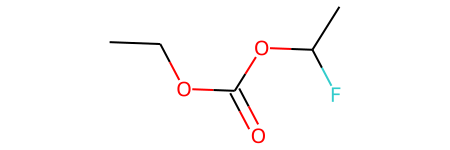

In [87]:
visualize_smile('CCOC(=O)OC(C)F')

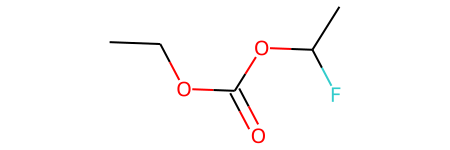

In [88]:
visualize_smile('CCOC(=O)OC(C)F')

In [97]:
dct['CCOC(=O)OC(C)F']

14

In [105]:
single_comp_ind = []
act_test_ind = test_ind.copy()
for i in range(len(test_df)):
    sm = test_df['solv_2_sm'][i]
    try:
        if m.isnan(sm) == True:  ## try this if np.nan does not work; however it will not work when there is a text
            single_comp_ind.append(i)
    except:
        act_test_ind.remove(test_ind[i])
        print(i)
        # print("Is not a single component")
print(len(single_comp_ind))
print(len(act_test_ind))

0
1
2
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
169
170
171
172
173
176
188
189
190
191
192
214
215
216
217
218
219
235
236
237
238
239
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
292
293
294
295
296
297
298
299
300
301
302
303
309
310
333
335
337
338
371
372
373
374
375
376
387
388
389
390
391
393
394
449
455
456
457
458
459
464
465
466
467
468
469
470
471
472
473
479
480
481
482
483
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
516
518
519
520
521
522
523
525
527
528
529
530
531
532
536
537
538
620
621
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
6

In [106]:
act_test_ind

[14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 8313,
 8314,
 8315,
 8316,
 8317,
 8318,
 8319,
 8320,
 8321,
 8322,
 8323,
 8324,
 8325,
 8326,
 8327,
 8368,
 8369,
 8371,
 8372,
 8373,
 8374,
 8375,
 8376,
 8377,
 8378,
 8379,
 8380,
 8381,
 8382,
 8383,
 8384,
 8385,
 8386,
 8387,
 8388,
 8389,
 8390,
 8391,
 8392,
 8393,
 8394,
 8395,
 8396,
 8397,
 8398,
 8399,
 8400,
 8401,
 8402,
 8403,
 8404,
 8405,
 8406,
 8407,
 8408,
 8409,
 8410,
 8411,
 8412,
 8413,
 7375,
 8803,
 9436,
 9437,
 9438,
 9439,
 9440,
 9441,
 7406,
 9442,
 7407,
 9443,
 7408,
 9444,
 422,
 423,
 424,
 425,
 426,
 427,
 428,
 429,
 430,
 431,
 432,
 433,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 7426,
 7412,
 7427,
 7428,
 8710,
 8711,
 8712,
 8713,
 8714,
 8715,
 8716,
 8717,
 8718,
 8719,
 8720,
 8776,
 8777,
 8778,
 2635,
 2636,
 2637,
 2638,
 2639,
 8779,
 8780,
 8781,
 8782,
 8783,
 8784,
 8785,
 8786,
 8787,
 8788,
 8789,
 8790,
 8791,
 8792,
 8793,
 

In [115]:
train_ind = [i for i in range(len(rest_df)) if i not in val_ind]
len(train_ind)

8227

In [116]:
train_df = rest_df.iloc[train_ind,:]
train_df.reset_index(drop=True, inplace=True)
train_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,O=C1OCCO1,COC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,2.459589
1,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.741937
2,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.955511
3,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.098612
4,CCOC(=O)OCC,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.193922
...,...,...,...,...,...,...
8222,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.809927
8223,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.724907
8224,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.833381
8225,O=S1(=O)CCCC1,CCOC(=O)OC,NaN,NaN,[Li+].F[P-](F)(F)(F)(F)F,1.712716


In [125]:
train_df_comb = rest_df_comb.iloc[train_ind,:]
train_df_add = rest_df_add.iloc[train_ind,:]
train_df_comb.reset_index(drop=True, inplace=True)
train_df_add.reset_index(drop=True, inplace=True)
print(train_df_comb.head())
train_df_add

          solv_comb_sm                                         salt_sm  \
0  O=C1OCCO1.COC(=O)OC                        [Li+].F[P-](F)(F)(F)(F)F   
1          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
2          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
3          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   
4          CCOC(=O)OCC  [Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F   

   conductivity_log  
0          2.459589  
1          0.741937  
2          0.955511  
3          1.098612  
4          1.193922  


,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,0.447059,0.552941,0.0,0.0,88.016044,90.031694,0.0,0.0,151.980186,1.0,25.0
1,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,10.0
2,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,20.0
3,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,30.0
4,1.000000,0.000000,0.0,0.0,118.062994,0.000000,0.0,0.0,286.933298,1.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
8222,0.300000,0.700000,0.0,0.0,120.024501,104.047344,0.0,0.0,151.980186,1.0,33.0
8223,1.000000,0.000000,0.0,0.0,120.024501,0.000000,0.0,0.0,151.980186,1.0,25.0
8224,1.000000,0.000000,0.0,0.0,120.024501,0.000000,0.0,0.0,151.980186,1.0,33.0
8225,1.000000,0.000000,0.0,0.0,120.024501,0.000000,0.0,0.0,151.980186,1.0,25.0


In [119]:
train_solv_freq = frequency_count(train_df)
train_solv = list(train_solv_freq.keys())
train_solv_freq

{'O=C1OCCO1': 2510,
 'COC(=O)OC': 538,
 'CCOC(=O)OCC': 2455,
 'CCOC(=O)OC': 517,
 'CC1COC(=O)O1': 5794,
 'ClCCl': 109,
 'C1CCOC1': 261,
 'CC1CCCO1': 253,
 'COCCOC': 552,
 'C1COCO1': 96,
 'O=C1CCCO1': 451,
 'CC#N': 201,
 'CC(=O)OC': 134,
 'COCOC': 108,
 'CCOC(=O)C': 405,
 'C1COB(OCCOB2OCCCO2)OC1': 115,
 'COCCOCCOCCOC': 139,
 'COCCOCCOCCOCCOC': 119,
 'N#CCCC#N': 117,
 'O=S1(=O)CCCC1': 247}

In [120]:
# test_solv_max_sim = []
for i in range(len(train_solv)):
    max_sim, ind = check_similarity(train_solv[i])
    sm_max_sim = test_single_solv[ind]
    if max_sim == 1.0:
        print(train_solv[i], max_sim, sm_max_sim)
    # test_solv_max_sim.append(max_sim)

COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [102]:
print(len(rest_df))
print(len(val_ind))

9290
1130


In [8]:
# val_df_comb = save_val_set(df_comb)
# # val_df_comb.to_csv('val_multi_comp_comb.csv', index=False)
# val_df_comb

,solv_comb_sm,salt_sm,conductivity_log
45,FC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.832909
46,FC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.163151
47,FC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.481605
48,FC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,1.686399
49,FC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,2.163323
...,...,...,...
10191,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,1.547563
10192,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,2.624669
10193,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,2.772589
10194,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,2.687847


In [126]:
train_df.to_csv('train_multi_comp.csv', index=False)
train_df_comb.to_csv('train_multi_comp_comb.csv', index=False)
train_df_add.to_csv('train_multi_comp_add.csv', index=False)

In [127]:
val_df.to_csv('val_multi_comp.csv', index=False)
val_df_comb.to_csv('val_multi_comp_comb.csv', index=False)
val_df_add.to_csv('val_multi_comp_add.csv', index=False)

In [128]:
test_df_single.to_csv('test_multi_comp.csv', index=False)
test_df_single_comb.to_csv('test_multi_comp_comb.csv', index=False)
test_df_single_add.to_csv('test_multi_comp_add.csv', index=False)

**Try another idea -- cannot be applied**

In [44]:
rem_ind = set()
for i in range(len(test_df)):
    for j in range(4):
        if test_df[cols[j]][i] in rest_solv:
            # print(test_df[cols[j]][i], i)
            rem_ind.add(i)
print(len(rem_ind))

348


In [45]:
rem_ind

{0,
 1,
 2,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 169,
 170,
 171,
 172,
 173,
 176,
 188,
 189,
 190,
 191,
 192,
 214,
 215,
 216,
 217,
 218,
 219,
 235,
 236,
 237,
 238,
 239,
 272,
 273,
 274,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 292,
 293,
 294,
 295,
 296,
 297,
 298,
 299,
 300,
 301,
 302,
 303,
 309,
 310,
 333,
 335,
 337,
 338,
 371,
 372,
 373,
 374,
 375,
 376,
 387,
 388,
 389,
 390,
 391,
 393,
 394,
 449,
 455,
 456,
 457,
 458,
 459,
 464,
 465,
 466,
 467,
 468,
 469,
 470,
 471,
 472,
 473,
 479,
 480,
 481,
 482,
 

In [47]:
# test_df_c = test_df.copy()
rem_ind = list(rem_ind)
test_df.drop(index=rem_ind, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_df

,solv_1_sm,solv_2_sm,solv_3_sm,solv_4_sm,salt_sm,conductivity_log
0,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.000000
1,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.262364
2,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.470004
3,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.641854
4,CCOC(=O)OC(C)F,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0.955511
...,...,...,...,...,...,...
553,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.976234
554,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-4.422849
555,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-2.673649
556,COCCOCCOCCOCC1COB(c2ccc(B3OCC(COCCOCCOCCOC)O3)...,NaN,NaN,NaN,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,-1.469676


In [48]:
test_df_comb.drop(index=rem_ind, inplace=True)
test_df_comb.reset_index(drop=True, inplace=True)
test_df_add.drop(index=rem_ind, inplace=True)
test_df_add.reset_index(drop=True, inplace=True)
print(len(test_df_comb))
test_df_add

558


,solv_ratio_1,solv_ratio_2,solv_ratio_3,solv_ratio_4,mol_wt_solv_1,mol_wt_solv_2,mol_wt_solv_3,mol_wt_solv_4,mol_wt_salt,conc_salt,temperature
0,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,10.0
1,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,20.0
2,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,30.0
3,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,40.0
4,1.0,0.0,0.0,0.0,136.053572,0.0,0.0,0.0,286.933298,1.00,60.0
...,...,...,...,...,...,...,...,...,...,...,...
553,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,25.0
554,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,30.0
555,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,50.0
556,1.0,0.0,0.0,0.0,570.301888,0.0,0.0,0.0,286.933298,0.88,70.0


In [49]:
test_solv_c_dict = frequency_count(test_df)
test_solv_c = list(test_solv_c_dict.keys())
test_solv_c

['CCOC(=O)OC(C)F',
 'CC(OC(=O)OCC(F)(F)F)F',
 'CCOCCOCCF',
 'CCOCCOCC(F)F',
 'CCOCCOCC(F)(F)F',
 'COCCCCOC',
 'COCC(F)(F)C(F)(F)COC',
 'COCCO[Si](C)(C)C',
 'COCCOCCO[Si](C)(C)C',
 'COCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCOCCO[Si](C)(C)C',
 'COCCOCCOCCOCCOCCOCCOCCO[Si](C)(C)C',
 'C[Si](C)(C)OCCOCCOCCO[Si](C)(C)C',
 'C[Si](C)(C)OCCOCCOCCOCCO[Si](C)(C)C',
 'COC(=O)C(F)F',
 'COCCOCCOCCO[Si](C)(C)CCCOCC1COC(=O)O1',
 'C[N+](=O)[O-]',
 'CC(=O)OCCF',
 'C=CCCCOCC1COC(=O)O1',
 'CO[Si](CCCOCC1COC(=O)O1)(OC)OC',
 'CCO[Si](CCCOCC1COC(=O)O1)(OCC)OCC',
 'C[Si](C)(C)O[Si](C)(C)CCCOCC1COC(=O)O1',
 'CCOC(=O)CF',
 'COCCOCCOCCC[Si](C)(F)F',
 'COCCOCCOCCC[Si](C)(C)F',
 'COCCOCCOCCC[Si](C)(C)C',
 'COCCO[Si](C)(C)CCCC#N',
 'O=C(OCF)OCF',
 'COCCOCCO[Si](C)(C)CCCC#N',
 'COCCOCCOCCO[Si](C)(C)CCCC#N',
 'COCCO[Si](C)(CCC#N)OCCOC',
 'COCCO[Si](CCC#N)(OCCOC)OCCOC',
 'CCOCCOC',
 'COC(=O)OCCCF',
 'COC(=O)OCCC(F)(F)F',
 'COC(=O)OCC(F)(F)C(F)F',
 'COC(=O)OCC(F)(F)C(F)(F)F',
 'COCCOCCF',
 '

In [52]:
ref_mol = [Chem.MolFromSmiles(sm) for sm in test_solv_c]
ref_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in ref_mol]

In [53]:
for i in range(len(rest_solv)):
    max_sim, ind = check_similarity(rest_solv[i])
    sm_max_sim = test_solv_c[ind]
    if max_sim == 1.0:
        print(rest_solv[i], max_sim, sm_max_sim)

COCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC
COCCOCCOCCOCCOC 1.0 COCCOCCOCCOCCOCCOCCOCCOCCOCCOCCOC


In [54]:
test_df.to_csv('test_multi_comp_c.csv', index=False)
test_df_comb.to_csv('test_multi_comp_comb_c.csv', index=False)
test_df_add.to_csv('test_multi_comp_add_c.csv', index=False)